#**Desafio Técnico** 





```
# Jeydson Lopes da Silva
```


Desenvolver um modelo que reconheça e classifique 
imagens de sinais de trânsito 

a partir do banco de 
dados do [Sinais de trânsito | Kaggle](https://www.kaggle.com/venkateshroshan/traffic-signs).


# **Pipeline**


*   Load Data
*   Dataset Summary / Exploration / Featuring
> *   Shuffling.
> *   Grayscaling
> *   Local Histogram Equalization
> *   Normalization
*   Model
*   Model Training and Evaluation
*   Testing the Model Using the Test Set
*   Testing the Model on New Images
*   Deployment



A estrutura do notebook foi desenvolvida no COLAB, uma vez que há uma facilidade no uso de bibliotecas implementadas bem como sua estrutura amigável de desenvolvimento.  

Requerimentos:

TensorFlow 1.15 (GPU support)

In [ ]:
#Bibliotecas necessárias

import numpy as np
import pickle
import matplotlib.pyplot as plt
import random
import cv2
import skimage.morphology as morp
from skimage.filters import rank
from sklearn.utils import shuffle
import csv
import os
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from sklearn.metrics import confusion_matrix

# Verificação GPU
print(tf.test.gpu_device_name())

# Versão do TensorFlow 
tf.__version__

# **1 - Load Data**

Há duas opções para o carregamento dos dados

A primeira opção é realizar o carregamento manual dos dados a partir dos arquivos .csv na

pasta "Traffic Signs" (realizado na próxima etapa)

A segunda opção é carregar os dados previamente organizados na pasta "data_signs"

**A primeira opção será utilizada por default

In [ ]:
#Carregar arquivos de dados salvos

# train_data = "./data_signs/train.pickle"
# valid_data = "./data_signs/valid.pickle"
# test_data = "./data_signs/test.pickle"

# with open(train_data, mode='rb') as f:
#     train = pickle.load(f)
# with open(valid_data, mode='rb') as f:
#     valid = pickle.load(f)
# with open(test_data, mode='rb') as f:
#     test = pickle.load(f)

# **2 - Dataset Summary / Exploration / Featuring**

Os dados serão organizados como dicionários contendo 4 chaves:

**'features'** é um array multidimensional (4D) dos pixels das imagens dos traffic signs 

(num examples, width, height, channels).

**'labels'** é um array (1D) contendo o label/class do traffic sign. 

**'sizes'** é uma lista contendo tuplas (width, height), representando os a largura e tamanho orginais das imagens.

**'coords'** é uma lista contendo tuplas, (x1, y1, x2, y2), representando as coordenadas dos

bounding box em torno do sinal na imagem.

As imagens inicialmente encontram-se com diferentes larguras e alturas, o que dificultar um pouco o 

processo de aprendizaddo modelo.

De formar a uniformizar as imagens, utiliza-se um função para tornar todas as imagens

 no formato (32,32,3) para melhor desempenho do modelo

In [6]:
#Imagem Resize (32,32,3)

def resize_cv(img):
    return cv2.resize(img, (32, 32), interpolation = cv2.INTER_AREA)



Primeiro realiza-se um mapeamento das classes a partir do Labels.csv



In [7]:
# Mapear os IDclasses em signs 

path_labels = "./Traffic Signs/Labels.csv"
signs = []

with open(path_labels, 'r') as csvfile:
    signnames = csv.reader(csvfile, delimiter=',')
    next(signnames,None)
    for row in signnames:
        signs.append(row[1])
    csvfile.close()

Em seguida é feito um mapeamento do cojunto de treinamento ('Train.csv') e do conjunto 

de teste ('Test.csv') para as variáveis de treinamento, teste e validação, respeito o formato dos dados ( dicionário contendo: **'features', 'labels','sizes','coords'**).


In [12]:
# Mapear
def mapping(treino, teste):


  sizes = []  #tamanhos originais (sizes)
  coords =[] #Bound Boxes
  caminhos = [] #Camimhos para imagens
  lab = [] #IDclasses
  indx = []
  for i in range(4500):
    indx.append(random.randint(0, 39000))
    

#Percorrer o .csv
  with open(treino, 'r') as csvfile:
      signnames = csv.reader(csvfile, delimiter=',')
      next(signnames,None)
      for row in signnames:
          sizes.append((int(row[0]),int(row[1])))
          coords.append((int(row[2]),int(row[3]),int(row[4]),int(row[5])))
          caminhos.append('./Traffic Signs/'+ (row[7]))
          lab.append(int(row[6]))

      sizes_valid = []
      coords_valid = []
      caminhos_valid = []
      lab_valid = []
      for j in range(len(indx)):
          sizes_valid.append(sizes[indx[j]])
          coords_valid.append(coords[indx[j]])
          caminhos_valid.append(caminhos[indx[j]])
          lab_valid.append(lab[indx[j]])
      
      x = sorted(indx, key=int,  reverse=True)
      w = 0
      for i in x:
        if w == 0:
          del(sizes[i])
          del(coords[i])
          del(caminhos[i])
          del(lab[i])
        else:
          del(sizes[i-1])
          del(coords[i-1])
          del(caminhos[i-1])
          del(lab[i-1])
        w += 1

         #   #  criar o array das imagens    
      img_train =[]
      for i in caminhos:
        imagem = cv2.imread(i)
        r = resize_cv(imagem)
        img_train.append(r) 
      
      img_valid = []
      for i in caminhos_valid:
        imagem = cv2.imread(i)
        r = resize_cv(imagem)
        img_valid.append(r)       

      img_train = np.asarray(img_train)     
      img_valid = np.asarray(img_valid)     

      csvfile.close()
     
 #Percorrer o .csv
  
  sizes_test = []
  coords_test = []
  caminhos_test = []
  lab_test = []

  with open(teste, 'r') as csvfile:
      signnames = csv.reader(csvfile, delimiter=',')
      next(signnames,None)
      for row in signnames:
          sizes_test.append((int(row[0]),int(row[1])))
          coords_test.append((int(row[2]),int(row[3]),int(row[4]),int(row[5])))
          caminhos_test.append('./Traffic Signs/'+ (row[7]))
          lab_test.append(int(row[6]))    
     
      img_test = []
      for i in caminhos_test:
        imagem = cv2.imread(i)
        r = resize_cv(imagem)
        img_test.append(r)   

      img_test = np.asarray(img_test)        

      csvfile.close()    
     

  train ={'features':img_train,'labels':lab,'sizes':sizes,'coords':coords}
  
  valid = {'features':img_valid,'labels':lab_valid,'sizes':sizes_valid,'coords':coords_valid}
  test ={'features':img_test,'labels':lab_test,'sizes':sizes_test,'coords':coords_test}
  
  return train, test, valid


In [13]:
#Mapeamento dados (TRAIN, TEST, VALID)

treino = "./Traffic Signs/Train.csv"
teste = "./Traffic Signs/Test.csv"
train, test, valid  = mapping(treino,teste)

#Salvar dados

with open('./data_signs/train.pickle', 'wb') as f:
    pickle.dump(train, f)
with open('./data_signs/test.pickle', 'wb') as f:
    pickle.dump(train, f)   
with open('./data_signs/valid.pickle', 'wb') as f:
    pickle.dump(train, f)

In [15]:
#Váriaveis do dataset

X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

# Número do exemplo de treinamentos
n_train = X_train.shape[0]

# Número do exemplo de teste
n_test = X_test.shape[0]

# Número do exemplo de validção
n_validation = X_valid.shape[0]

# Imagem shape
image_shape = X_train[0].shape

#Número de classes no dataset
n_classes = len(np.unique(y_train))

print("Número do exemplo de treinamentos: ", n_train)
print("Número do exemplo de teste: ", n_test)
print("Número do exemplo de validçãos: ", n_validation)
print("Imagem shape =", image_shape)
print("Número de classes no dataset =", n_classes)

Número do exemplo de treinamentos:  34709
Número do exemplo de teste:  12630
Número do exemplo de validçãos:  4500
Imagem shape = (32, 32, 3)
Número de classes no dataset = 43


De forma a melhor visualizar o as imagens, utilizar as funções 
para listar e exibir

In [20]:
#Listar imagens

def list_images(dataset, dataset_y, ylabel="", cmap=None):
    """
    Exibe uma lista de imagens em uma única figura com matplotlib.

    """
    plt.figure(figsize=(15, 16))
    for i in range(6):
        plt.subplot(1, 6, i+1)
        indx = random.randint(0, len(dataset))
        #Use gray scale color map if there is only one channel
        cmap = 'gray' if len(dataset[indx].shape) == 2 else cmap
        plt.imshow(dataset[indx], cmap = cmap)
        plt.xlabel(signs[dataset_y[indx]])
        plt.ylabel(ylabel)
        plt.xticks([])
        plt.yticks([])
        
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

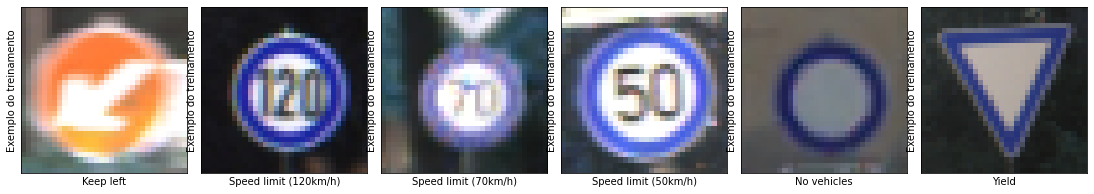

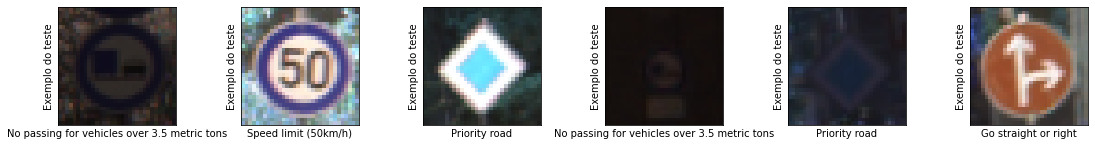

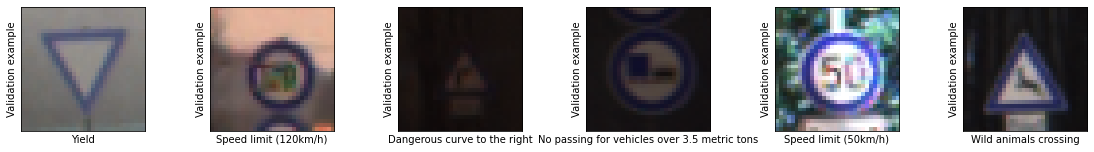

In [23]:
# Plotting sample examples
list_images(X_train, y_train, "Exemplo do treinamento")
list_images(X_test, y_test, "Exemplo do teste")
list_images(X_valid, y_valid, "Validation example")

Um histograma para visualizar a quantidade de imagens por classe nos conjuntos de treinamento, teste e validação

In [24]:
#histograma da contagem de imagens em cada classe única.

def histogram_plot(dataset, label):
    """
    Histograma dos dados de entrada.

    """
    hist, bins = np.histogram(dataset, bins=n_classes)
    width = 0.75 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.bar(center, hist, align='center', width=width, color = 'r', edgecolor='blue')
    plt.xlabel(label)
    plt.ylabel("Número de imagens")
    plt.show()


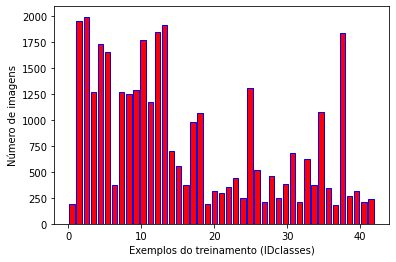

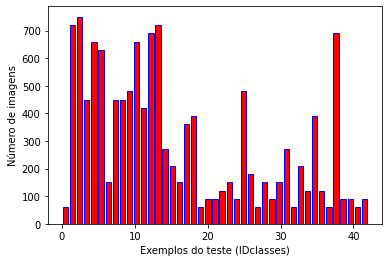

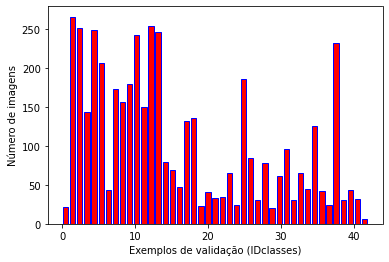

In [30]:
#Traçando histogramas da contagem de cada sinal

histogram_plot(y_train, "Exemplos do treinamento (IDclasses)")
histogram_plot(y_test, "Exemplos do teste (IDclasses)")
histogram_plot(y_valid, "Exemplos de validação (IDclasses)")

Uma vez os dados estando corretamento visualizados, aplicam-se  várias etapas de pré-processamento (além do resize) às imagens de entrada para obter os melhores resultados possíveis.

Usaremos as seguintes técnicas de pré-processamento:

**Shuffling.**

**Grayscaling.**

**Local Histogram Equalization.**

**Normalization**




**Shuffling:** *De forma geral, mistura-se os dados de treinamento para aumentar a aleatoriedade e a *variedade no conjunto de dados* de treinamento, para que o modelo seja mais estável. Usaremos sklearn para embaralhar nossos dados.

In [31]:
#Misturar os dados de treinamento 

X_train, y_train = shuffle(X_train, y_train)

***Grayscaling:***: Imagens  em tons de cinza (ao invés de cores) melhora a precisão da rede neural. Nesse caso, utiliza-se o OpenCV para converter as imagens de treinamento em escala de cinza.

In [32]:
#Conveter uma imagem colorida para uma escala cinza

def gray(image):
    """
    Converta as imagens para a escala de cinza.

    """
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

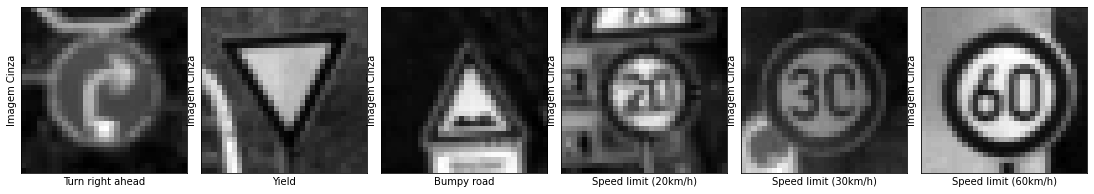

In [33]:
# Imagens em escala cinza
gray_images = list(map(gray, X_train))
list_images(gray_images, y_train, "Imagem Cinza", "gray")

**Local Histogram Equalization:** Uma vez que o dataset utiliza de imagens reais (baixo contraste), utiliza-se esta técnica para distribuir os valores de intensidade mais frequentes em uma imagem, aprimorando assim essas imagens. Assim sendo, utiliza-se o skimage para aplicar a equalização do histograma local às imagens de treinamento.

In [34]:
#Equalizar histogramas

def local_histo_equalize(image):
    """
    Eequalização de histograma local a imagens em tons de cinza.
       
    """
    kernel = morp.disk(30)
    img_local = rank.equalize(image, selem=kernel)
    return img_local

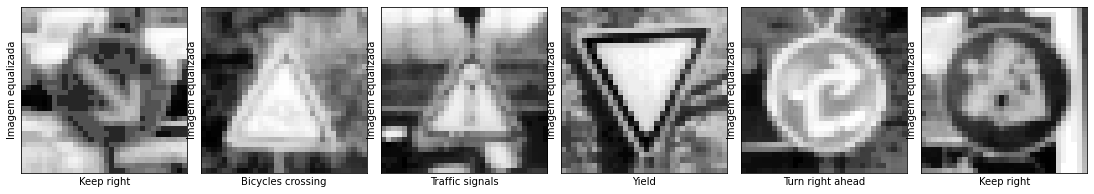

In [35]:
#Imagens após a equalização do histograma local

equalized_images = list(map(local_histo_equalize, gray_images))
list_images(equalized_images, y_train, "Imagem equalizada", "gray")

***Normalization:*** Esta é um processamento importante, pois os dados da imagem devem ser normalizados para que os dados tenham média zero e variância igual. A normalização busca modificar a faixa de valores da intensidade do pixel.

In [36]:
#Normalizar imagens

def image_normalize(image):
    """
    Normaliza as imagens na escala [0, 1].
       
    """
    image = np.divide(image, 255)
    return image

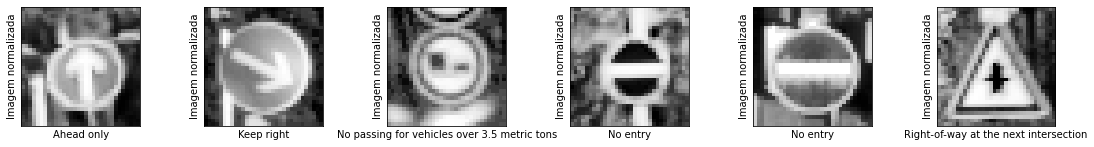

In [37]:
# Imagens depois da normalização

n_training = X_train.shape
normalized_images = np.zeros((n_training[0], n_training[1], n_training[2]))
for i, img in enumerate(equalized_images):
    normalized_images[i] = image_normalize(img)
list_images(normalized_images, y_train, "Imagem normalizada", "gray")
normalized_images = normalized_images[..., None]

Uma vez definido os pré-processamentos da imagem, utiliza-se uma função para aplicá-los as imagens

In [38]:
#Pré-processamento das imagens

def preprocess(data):
    """
    Aplicando as etapas de pré-processamento aos dados.
   
    """
    gray_images = list(map(gray, data))
    equalized_images = list(map(local_histo_equalize, gray_images))
    n_training = data.shape
    normalized_images = np.zeros((n_training[0], n_training[1], n_training[2]))
    for i, img in enumerate(equalized_images):
        normalized_images[i] = image_normalize(img)
    normalized_images = normalized_images[..., None]
    return normalized_images

# **3 - Model**

Nesta etapa, iremos projetar e implementar um modelo de aprendizado profundo que aprende a reconhecer sinais de trânsito do dataset Traffic Sign do Kaggle.

No modelo será utilizado redes convolucionais (ConvNets) para classificar as imagens deste conjunto de dados. De forma geral, as ConvNets são ideais  para reconhecer padrões visuais diretamente dos pixels de imagens com pré-processamento mínimo. As ConvNets aprendem automaticamente hierarquias de recursos invariáveis em todos os níveis a partir dos dados. 

O modelo é implementado utilizando o framework TensorFlow.

**VGGNet**

A VGGNet apresenta uma melhoria em relação a algumas ConvNEts, como a Lenet por exemplo. Este fato se dá pela avaliação completa de redes de profundidade crescente usando uma arquitetura com filtros de convolução muito pequenos (3x3).

Nesse caso, a arquitetura VGGNet utilizará 12 camadas.

Input -- Convolution -- ReLU --Convolution -- ReLU --Pooling -- Convolution --ReLU -- Convolution -- ReLU -- Pooling -- Convolution -- ReLU -- Convolution -- ReLU -- Pooling -- FullyConnected -- ReLU -- FullyConnected -- ReLU -- FullyConnected

De formar a facilitar o desenvolvimento do modelo,
a arquitetura, parâmetros e hiperâmetros 

utilizados foram obtidos a partir de aplicações  semelhantes de trabalhos relacionados.

In [39]:
#Modelo VGGnet 

class VGGnet:  

    def __init__(self, n_out=43, mu=0, sigma=0.1, learning_rate=0.001):
        # Hiperparâmetros

        self.mu = mu
        self.sigma = sigma

        # Camada 1 (Convolutional): Input = 32x32x1. Output = 32x32x32
        self.conv1_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 1, 32), mean = self.mu, stddev = self.sigma))
        self.conv1_b = tf.Variable(tf.zeros(32))
        self.conv1   = tf.nn.conv2d(x, self.conv1_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv1_b

        # Ativação ReLu 
        self.conv1 = tf.nn.relu(self.conv1)

        # Camada 2 (Convolutional): Input = 32x32x32. Output = 32x32x32
        self.conv2_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 32, 32), mean = self.mu, stddev = self.sigma))
        self.conv2_b = tf.Variable(tf.zeros(32))
        self.conv2   = tf.nn.conv2d(self.conv1, self.conv2_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv2_b

        # Ativação ReLu 
        self.conv2 = tf.nn.relu(self.conv2)

        # Camada 3 (Pooling): Input = 32x32x32. Output = 16x16x32
        self.conv2 = tf.nn.max_pool(self.conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        self.conv2 = tf.nn.dropout(self.conv2, keep_prob_conv)

        # Camada  4 (Convolutional): Input = 16x16x32. Output = 16x16x64
        self.conv3_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 32, 64), mean = self.mu, stddev = self.sigma))
        self.conv3_b = tf.Variable(tf.zeros(64))
        self.conv3   = tf.nn.conv2d(self.conv2, self.conv3_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv3_b

        # Ativação ReLu 
        self.conv3 = tf.nn.relu(self.conv3)

        # Camada 5 (Convolutional): Input = 16x16x64. Output = 16x16x64
        self.conv4_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 64, 64), mean = self.mu, stddev = self.sigma))
        self.conv4_b = tf.Variable(tf.zeros(64))
        self.conv4   = tf.nn.conv2d(self.conv3, self.conv4_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv4_b

        # Ativação ReLu 
        self.conv4 = tf.nn.relu(self.conv4)

        # Camada 6 (Pooling): Input = 16x16x64. Output = 8x8x64.
        self.conv4 = tf.nn.max_pool(self.conv4, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        self.conv4 = tf.nn.dropout(self.conv4, keep_prob_conv) # dropout

        # Camada 7 (Convolutional): Input = 8x8x64. Output = 8x8x128.
        self.conv5_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 64, 128), mean = self.mu, stddev = self.sigma))
        self.conv5_b = tf.Variable(tf.zeros(128))
        self.conv5   = tf.nn.conv2d(self.conv4, self.conv5_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv5_b

        # Ativação ReLu 
        self.conv5 = tf.nn.relu(self.conv5)

        # Layer 8 (Convolutional): Input = 8x8x128. Output = 8x8x128.
        self.conv6_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 128, 128), mean = self.mu, stddev = self.sigma))
        self.conv6_b = tf.Variable(tf.zeros(128))
        self.conv6   = tf.nn.conv2d(self.conv5, self.conv6_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv6_b

        # Ativação ReLu 
        self.conv6 = tf.nn.relu(self.conv6)

        # Camada 9 (Pooling): Input = 8x8x128. Output = 4x4x128.
        self.conv6 = tf.nn.max_pool(self.conv6, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        self.conv6 = tf.nn.dropout(self.conv6, keep_prob_conv) # dropout

        # Flatten. Input = 4x4x128. Output = 2048
        self.fc0   = flatten(self.conv6)

        # Layer 10 (Fully Connected): Input = 2048. Output = 128.
        self.fc1_W = tf.Variable(tf.truncated_normal(shape=(2048, 128), mean = self.mu, stddev = self.sigma))
        self.fc1_b = tf.Variable(tf.zeros(128))
        self.fc1   = tf.matmul(self.fc0, self.fc1_W) + self.fc1_b

        # Ativação ReLu 
        self.fc1    = tf.nn.relu(self.fc1)
        self.fc1    = tf.nn.dropout(self.fc1, keep_prob) # dropout

        # Camada 11 (Fully Connected): Input = 128. Output = 128
        self.fc2_W  = tf.Variable(tf.truncated_normal(shape=(128, 128), mean = self.mu, stddev = self.sigma))
        self.fc2_b  = tf.Variable(tf.zeros(128))
        self.fc2    = tf.matmul(self.fc1, self.fc2_W) + self.fc2_b

        # Ativação ReLu 
        self.fc2    = tf.nn.relu(self.fc2)
        self.fc2    = tf.nn.dropout(self.fc2, keep_prob) # dropout

        # Camada 12 (Fully Connected): Input = 128. Output = n_out
        self.fc3_W  = tf.Variable(tf.truncated_normal(shape=(128, n_out), mean = self.mu, stddev = self.sigma))
        self.fc3_b  = tf.Variable(tf.zeros(n_out))
        self.logits = tf.matmul(self.fc2, self.fc3_W) + self.fc3_b

        # Treinamento

        self.one_hot_y = tf.one_hot(y, n_out)
        self.cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=self.logits, labels=self.one_hot_y)
        self.loss_operation = tf.reduce_mean(self.cross_entropy)
        self.optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
        self.training_operation = self.optimizer.minimize(self.loss_operation)

        # Acurácia

        self.correct_prediction = tf.equal(tf.argmax(self.logits, 1), tf.argmax(self.one_hot_y, 1))
        self.accuracy_operation = tf.reduce_mean(tf.cast(self.correct_prediction, tf.float32))

        # Salvar variáveis
        self.saver = tf.train.Saver()
        
    def y_predict(self, X_data, BATCH_SIZE=64):
        num_examples = len(X_data)
        y_pred = np.zeros(num_examples, dtype=np.int32)
        sess = tf.get_default_session()
        for offset in range(0, num_examples, BATCH_SIZE):
            batch_x = X_data[offset:offset+BATCH_SIZE]
            y_pred[offset:offset+BATCH_SIZE] = sess.run(tf.argmax(self.logits, 1), 
                               feed_dict={x:batch_x, keep_prob:1, keep_prob_conv:1})
        return y_pred
    
    def evaluate(self, X_data, y_data, BATCH_SIZE=64):
        num_examples = len(X_data)
        total_accuracy = 0
        sess = tf.get_default_session()
        for offset in range(0, num_examples, BATCH_SIZE):
            batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
            accuracy = sess.run(self.accuracy_operation, 
                                feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0, keep_prob_conv: 1.0 })
            total_accuracy += (accuracy * len(batch_x))
        return total_accuracy / num_examples

# **4 - Model Training and Evaluation**

Nesta etapa o modelo é utilizado para calcular a softmax cross entropy entre os logits e os labels das imagens.

Como o TensorFlow é utilizado, é necessário alocar espaço para os resultados.
Neses caso, **x** é um espaço reservado para um lote de imagens de entrada. O **y** é um espaço reservado para um lote de rótulos de saída.

In [42]:
# x - espaço reservado para um batch das inputs da imagem
# y - espaço reservado para um batch dos labels da saída da imagem

x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))

Além disso, um problema sério nas redes neruais profundas é o overfitting. 

De forma a minimizar este problema pode-se utilizaro Dropout. O Dropout é uma técnica busca descartar unidades aleatoriamente (junto com suas conexões) da rede neural durante o treinamento. Isso evita que as unidades se adaptem demais. 

As variáveis** keep_prob** e **keep_prob_conv** são utilizadas para controlar a taxa de dropout ao treinar a ConvNet.

In [43]:
keep_prob = tf.placeholder(tf.float32)       # For fully-connected layers
keep_prob_conv = tf.placeholder(tf.float32)  # For convolutional layers

In [44]:
# Validation set preprocessing
X_valid_preprocessed = preprocess(X_valid)

In [45]:
#Parâmetros específicos para o treinamento
EPOCHS = 30
BATCH_SIZE = 64
DIR = 'Saved_Models'

**Pipeline de treinamento para treinar o modelo.**


*   Antes de cada época, embaralharemos o conjunto de treinamento.
*  Após cada época, medimos a perda e a precisão do conjunto de validação.
*   E após o treinamento, vamos salvar o modelo.
*  Uma baixa precisão nos conjuntos de treinamento e validação implica em ajuste insuficiente. Uma alta precisão no conjunto de treinamento, mas baixa precisão no conjunto de validação implica overfitting.

In [46]:
#Pipiline do treinamento do modelo

VGGNet_Model = VGGnet(n_out = n_classes)
model_name = "VGGNet"

# Validation set preprocessing
X_valid_preprocessed = preprocess(X_valid)
one_hot_y_valid = tf.one_hot(y_valid, 43)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(y_train)
    print("Training...")
    print()
    for i in range(EPOCHS):
        normalized_images, y_train = shuffle(normalized_images, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = normalized_images[offset:end], y_train[offset:end]
            sess.run(VGGNet_Model.training_operation, 
            feed_dict={x: batch_x, y: batch_y, keep_prob : 0.5, keep_prob_conv: 0.7})

        validation_accuracy = VGGNet_Model.evaluate(X_valid_preprocessed, y_valid)
        print("EPOCH {} : Validation Accuracy = {:.3f}%".format(i+1, (validation_accuracy*100)))
    VGGNet_Model.saver.save(sess, os.path.join(DIR, model_name))
    print("Model saved")

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Training...

EPOCH 1 : Validation Accuracy = 35.089%
EPOCH 2 : Validation Accuracy = 69.711%
EPOCH 3 : Validation Accuracy = 84.378%
EPOCH 4 : Validation Accuracy = 91.600%
EPOCH 5 : Validation Accuracy = 96.200%
EPOCH 6 : Validation Accuracy = 97.600%
EPOCH 7 : Validation Accuracy = 97.822%
EPOCH 8 : Validation Accuracy = 97.756%
EPOCH 9 : Validation Accuracy = 98.800%
EPOCH 10 : Validation Accuracy = 98.911%
EPOCH 11 : Validation Accuracy = 99.422%
EPOCH 12 : Validation Accuracy = 99.644%
EPOCH 13 : Validation Accuracy = 99.600%
EPOCH 14 : Validation Accuracy = 99.578%
EPOCH 15 : Validation Accuracy = 99.800%
EPOCH 16 : Validation Accuracy = 99.711%
EPOCH 17 : Validation Accuracy = 99.822%
EPOCH 18 : Validation Accuracy = 99.733%
EPOCH 19 : 


# **5 -Testing the Model Using the Test Set**


Utilizando o conjunto de testes, busca-se para medir a precisão do modelo em relação a exemplos desconhecidos.

In [47]:
# Pré-processamento do conjunto de teste
X_test_preprocessed = preprocess(X_test)

In [48]:
with tf.Session() as sess:
    VGGNet_Model.saver.restore(sess, os.path.join(DIR, "VGGNet"))
    y_pred = VGGNet_Model.y_predict(X_test_preprocessed)
    test_accuracy = sum(y_test == y_pred)/len(y_test)
    print("Acurácia do teste = {:.1f}%".format(test_accuracy*100))

INFO:tensorflow:Restoring parameters from Saved_Models/VGGNet
Acurácia do teste = 97.2%


De forma a melhor visuazliar o desempenho da classificação, elabora-se uma ***Matrix de confusão***

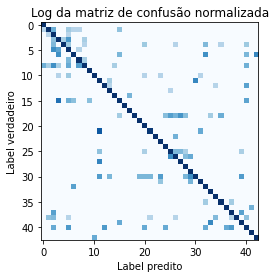

In [49]:
#Plotar a matriz de confusão

cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm = np.log(.0001 + cm)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Log da matriz de confusão normalizada')
plt.ylabel('Label verdadeiro')
plt.xlabel('Label predito')
plt.show()

# **6 - Testing the Model on New Images**

Nesta etapa, utiliza-se o modelo para prever a classe dos sinais de trânsito de imagens aleatórias.

In [54]:
# Carregando e redimensionando novas imagens de teste

new_test_images = []
path = './image_test/'
for image in os.listdir(path):
    img = cv2.imread(path + image)
    img = cv2.resize(img, (32,32))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    new_test_images.append(img)
new_IDs = [13, 3, 14, 27, 17]
print("Número de novos exemplos: ", len(new_test_images))

Número de novos exemplos:  5


Exibindo os novos exemplos de teste, com seus respectivos labels verdadeiros

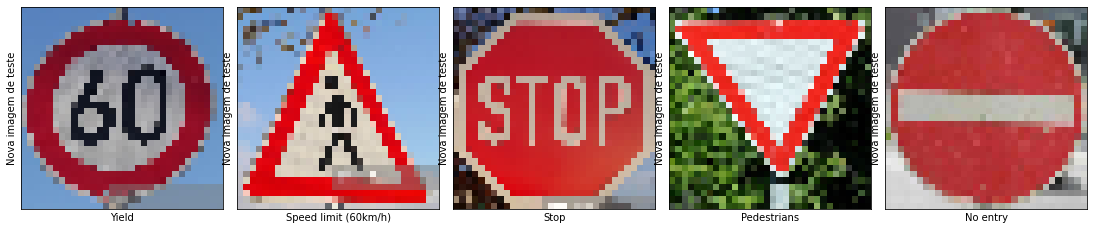

In [55]:
#Exibindo as imagens

plt.figure(figsize=(15, 16))
for i in range(len(new_test_images)):
    plt.subplot(2, 5, i+1)
    plt.imshow(new_test_images[i])
    plt.xlabel(signs[new_IDs[i]])
    plt.ylabel("Nova imagem de teste")
    plt.xticks([])
    plt.yticks([])
plt.tight_layout(pad=0, h_pad=0, w_pad=0)
plt.show()

In [56]:
#Pré-processamento dos novos dados de teste
new_test_images_preprocessed = preprocess(np.asarray(new_test_images))

INFO:tensorflow:Restoring parameters from Saved_Models/VGGNet
Acurárcia das novas imagens de teste = 40.0%


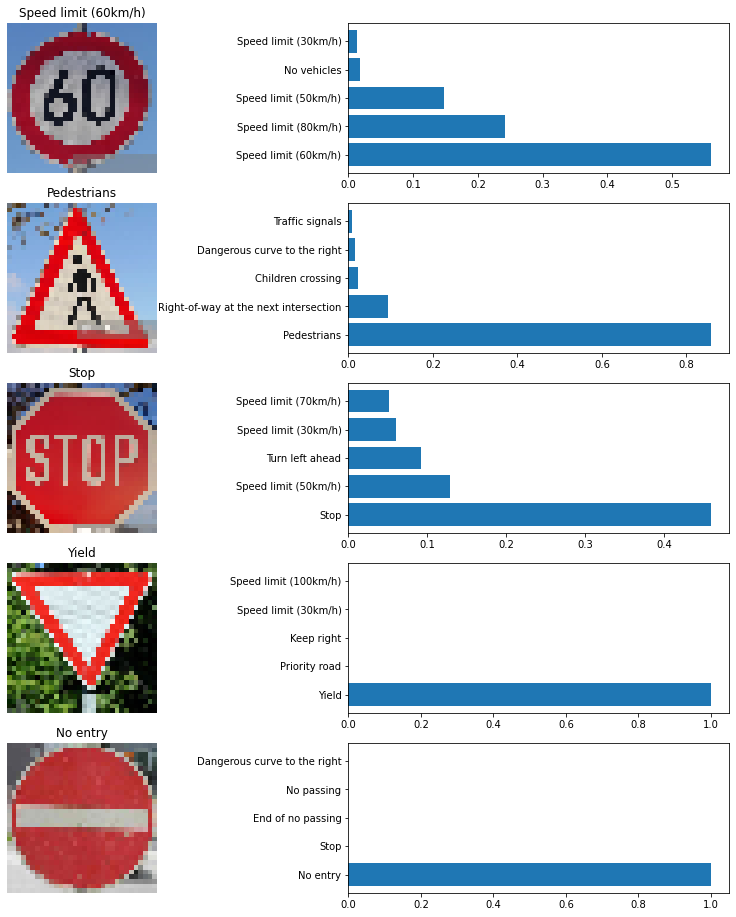

In [59]:
#Predição do modelo treinado

def y_predict_model(Input_data, top_k=5):
    """
    Gera as previsões do modelo sobre os dados de entrada e gera as principais probabilidades softmax.
       
    """
    num_examples = len(Input_data)
    y_pred = np.zeros((num_examples, top_k), dtype=np.int32)
    y_prob = np.zeros((num_examples, top_k))
    with tf.Session() as sess:
        VGGNet_Model.saver.restore(sess, os.path.join(DIR, "VGGNet"))
        y_prob, y_pred = sess.run(tf.nn.top_k(tf.nn.softmax(VGGNet_Model.logits), k=top_k), 
                             feed_dict={x:Input_data, keep_prob:1, keep_prob_conv:1})
    return y_prob, y_pred

y_prob, y_pred = y_predict_model(new_test_images_preprocessed)

test_accuracy = 0
for i in enumerate(new_test_images_preprocessed):
    accu = new_IDs[i[0]] == np.asarray(y_pred[i[0]])[0]
    if accu == True:
        test_accuracy += 0.2
print("Acurárcia das novas imagens de teste = {:.1f}%".format(test_accuracy*100))

plt.figure(figsize=(15, 16))
new_test_images_len=len(new_test_images_preprocessed)
for i in range(new_test_images_len):
    plt.subplot(new_test_images_len, 2, 2*i+1)
    plt.imshow(new_test_images[i]) 
    plt.title(signs[y_pred[i][0]])
    plt.axis('off')
    plt.subplot(new_test_images_len, 2, 2*i+2)
    plt.barh(np.arange(1, 6, 1), y_prob[i, :])
    labels = [signs[j] for j in y_pred[i]]
    plt.yticks(np.arange(1, 6, 1), labels)
plt.show()

Para um novo conjunto de imagens, a precisão do modelo cai bastante, podendo ainda ser ajustado no fim.


Usando VGGNet, conseguimos atingir uma taxa de precisão muito alta. Podemos observar que os modelos saturam após quase 10 épocas, então podemos economizar alguns recursos computacionais e reduzir o número de épocas para 20. Também podemos tentar outras técnicas de pré-processamento para melhorar ainda mais a precisão do modelo. Podemos melhorar ainda mais o modelo usando CNNs hierárquicos para primeiro identificar grupos mais amplos (como sinais de trânsito) e, em seguida, ter CNNs para classificar características mais refinadas (como o limite de velocidade real). Este modelo funcionará apenas em exemplos de entrada onde os sinais de trânsito estão centralizados no meio da imagem. Não tem a capacidade de detectar sinais nos cantos da imagem.

# **7 - Deployment**

Ao realizar o deployment de aplicações, em resumo cria-se versões dessas aplicações no correspondente no App Engine. De formar geral, pode-se implantar aplicativos inteiros, incluindo todo o código-fonte e arquivos de configuração, ou pode implantar e atualizar versões individuais ou arquivos de configuração.
Existem diversas opções interessantes para o deploymente, destacando o Google Cloud.

Google Cloud Platform provides infrastructure as a service, platform as a service, and serverless computing environments.